# ML Boot Camp Lesson 3
Copyright 2019

Author: Paul La Plante

License: BSD 2-clause

# CNNs 101
In this notebook, we'll work through how to make a convolutional neural network (CNN) using Keras and TensorFlow. If you haven't yet installed these packages, please refer to the Installation notebook.

## Theory
CNNs are a class of neural networks where one (or more) of the layers contain convolutions. CNNs do not need to consist entirely of convolution layers (and indeed, typically have one or more dense layers following convolutions), but they typically start with several convlutions layers. CNNs are well-suited for image recognition tasks, because they encode information about patterns in neighboring pixels within an input layer. A single "convolution layer" actually generally consists of three discrete operations: (1) a convolution operation, (2) an activation operation, and (3) a max pooling operation. We will now discuss each of these further.

### Convolutions
A _convolution_ is a mathematical operation where the values of a function are combined together with neighboring values to generate a "smoothed" output value. Mathematically, we can write a convolution as:

$$
(f * g)(t) \equiv \int_{-\infty}^\infty f(\tau) g(t-\tau) d\tau
$$

In the continuous case, the function $g(x)$ is typically a Gaussian function (or an approximation on a finite domain) or a "top hat" window (which has a normalized constant amplitude over some range). For the case of a two dimensional discrete convolution (which is the case for CNNs), given an two-dimensional input image $\vec{A} \in \mathbb{R}^{X\times Y}$ and a convolutional weights matrix $\vec{W} \in \mathbb{R}^{M \times N}$, the value in the output matrix $B(i,j)$ is given by:

$$
B(i,j) \equiv (A * W)(i, j) = \sum_{m=-M/2}^{M/2} \sum_{n=-N/2}^{N/2} W(m, n) \cdot A(i-m, j-n)
$$

The convolution thus has the effect of "mixing together" information in neighboring pixels in the input image. Initially, the values of the convolution window $\vec{W}$ are random, but as training progresses the values are updated to extract specific features of the input and hidden layers. These values can be positive or negative, but their magnitude is typically close to 1. When the network is fully trained, the convolution operation can be thought of as recognizing local patters in the data.

When applying the convolution, one can specify the _padding_ and the _stride_ to use. _Padding_ is adding additional data to the edges of the input images (typically zeros) so that the size of the output image can be the same as the input image. If there is no padding, and a dimension of the convolution kernel is greater than 1 (i.e., $M > 1$ or $N > 1$), then the output image must necessarily be smaller than the input. The _stride_ specifies how many pixels to translate the starting point of the convolutional filter for an adjacent pixel in the output image. For instance, a stride of 2 means that the convolutional kernel will only use _every other_ pixel as a starting location for the convolutional kernel, decreasing the size of the output image by a factor of 2 along the dimension of the stride.

### Max Pooling
Following the activation function being applied to each pixel of the output of the convolution, a _max pooling_ step is typically applied. This reduced the dimensionality of the data, which means fewer parameters to train in the next layer. It also serves to emphasize the most prominent features present in an output image.

A max pool, as its name implies, divides the image into equal chunks (or pools), and simply returns the maximum value within that pool. A typical size of the max pool is a 2x2 square, and so the max pool returns the largest of those 4 values as the new "output pixel". As with the padding and stride options mentioned above in the convolution step, this has the property of reducing the dimensionality of the output layers.

#### Visualize it!
Try to sketch out what is happening when a max pooling step is applied.

# Developing a CNN in Keras
Now that we've covered some of the basics of CNNs, let's build one using Keras. For the sake of example, we'll work through the same application as yesterday (classifying hand-written digits) but with using a CNN architecture.

In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

# make our model
model = Sequential()

# add layers
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

## Data Preprocessing
Now, we'll read in our dataset, the same one from yesterday. We also need to adjust the dimensions of the data, because of the CNN model we're using. We need to have 4 dimensions for our input data (number of images, x-dimension, y-dimension, color channel). Because we have just a single grayscale color channel, there is only a single rank along the last dimension. Nevertheless, we need to explicitly add it to our training and testing arrays. Also, we need to convert our labels to one-hot encoding.

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1) / 255.0
X_test = X_test.reshape(10000, 28, 28, 1) / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Visualizing the model
Let's use the same tools as we did yesterday to visualize our model.

In [3]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                184330    
Total params: 203,434
Trainable params: 203,434
Non-trainable params: 0
_________________________________________________________________
None


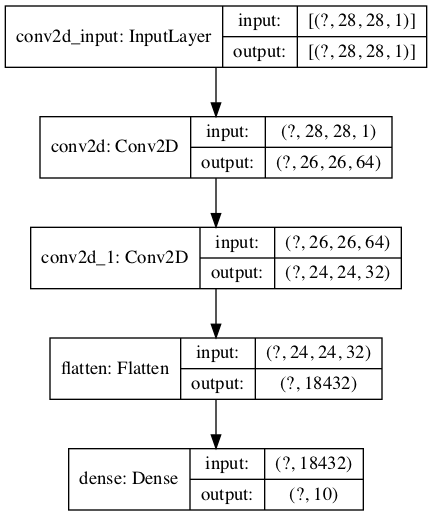

In [4]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="images/cnn_model_plot.png", show_shapes=True, show_layer_names=True)

## Compiling the Model
We'll need to compile the model. Let's use the same parameters as yesterday.

In [5]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Training the Model
Now it's time to train it!

In [6]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.1303 - accuracy: 0.9610 - val_loss: 0.0508 - val_accuracy: 0.9839
Epoch 2/3
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0495 - accuracy: 0.9850 - val_loss: 0.0487 - val_accuracy: 0.9842
Epoch 3/3
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.0339 - accuracy: 0.9897 - val_loss: 0.0484 - val_accuracy: 0.9845


Now we're at about 98% or 99% accurate! Getting better!

## Why did it take forever?
This time, the training took significantly longer than for the simple DNN. Naively, you might think that there were about twice as many parameters to train, so it should take longer. But it took much more than twice as long to train! The difference is that convolutions are much more computationally intensive to perform, both for the forward and backward propagation. This is part of the reason why GPUs are exceptionally good for ML applications in general and CNNs in particular: they are optimized for these types of operations (because of their primary application in generating computer graphics), and so training goes much faster.

# Peeking Under the Hood
In this case, the training took a very long time to run. We get some high level information about how the training is progressing, but it'd be nice to have more information. Fortunately, there's a tool that can help us do this. If we're using TensorFlow as the computational backend, the program _TensorBoard_ can be used to give us information about the network as it's running (and after it's been run).

To make use of TensorBoard, we add what's known as a `callback` to Keras's `fit` method on a Model object. Then from the command line, we open up TensorBoard and can visualize what's going on.

In [7]:
# reinstantiate our model, add a callback, and train again
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

# make a TensorBoard callback
cb = keras.callbacks.TensorBoard(log_dir="./logs")

# compile and train the model with our callback
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3,
          callbacks=[cb])

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.1306 - accuracy: 0.9603 - val_loss: 0.0583 - val_accuracy: 0.9814
Epoch 2/3
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0503 - accuracy: 0.9846 - val_loss: 0.0420 - val_accuracy: 0.9863
Epoch 3/3
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.0347 - accuracy: 0.9888 - val_loss: 0.0403 - val_accuracy: 0.9871


## Using TensorBoard
While that is running, open up a terminal, and navigate to the directory where these notebooks are. You should see a directory called `logs`. For example:
```bash
$ ls
Installation.ipynb  Lesson2.ipynb  Lesson4.ipynb  data    logs
Lesson1.ipynb       Lesson3.ipynb  Lesson5.ipynb  images

$ tensorboard --logdir=./logs
```
This will open up the TensorBoard program, which will give you access to quantities like the accuracy and loss values as a function of training epoch, as well as a visualization of the TensorFlow graph that's been generated by the model. There are a lot of nice features that TensorBoard has in it, so take a look!

# Further Reading
Here are some resources for learning more about convolutions.
* [Wikipedia article on convolution. The animations are useful for building intuition for one-dimensional convolutions.](https://en.wikipedia.org/wiki/Convolution)
* [A nice general overview of CNNs.](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
* [A detailed mathematical treatment of various CNN operations.](https://arxiv.org/pdf/1603.07285.pdf)